In [2]:
import pandas as pd
import numpy as np

In [3]:
#   1) LOADING THE LENDING CLUB accepted_2007_to_2018Q4.csv FILE WHILE FILTERING DOWN TO 2017-2018 DATA
apprTemp = []
df1 = pd.DataFrame()

# file to load
filename = r"C:\Users\olivi\Documents\Olivier\Training\Springboard Learning\Data Science Career Track\Capstone Project 1\Idea3 - Predicting Full Payment on LendingClub Lease Applications\datasets\accepted_2007_to_2018Q4.csv"

# use chunk size 100000
c_size = 100000

import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

for approved_chunk in pd.read_csv(filename,chunksize=c_size, iterator=True, low_memory=False):  
    
    # Filtering records via regular expression such that only records for the year 2018 are kept
    approved = approved_chunk[approved_chunk['issue_d'].str.contains('2018',na=False, regex=True)]
    
    # Putting the filtered data back together by appending each chunk to the next
    apprTemp.append(approved)

In [4]:
#   1) CONTINUED...
print("Database: CONCATENATING PROCESSED CHUNKS INTO A SINGLE DATAFRAME")
# CONCATENATING PROCESSED DATA
df1 = pd.concat(apprTemp)
print("Database: LOADED")
df1.info()

Database: CONCATENATING PROCESSED CHUNKS INTO A SINGLE DATAFRAME
Database: LOADED
<class 'pandas.core.frame.DataFrame'>
Int64Index: 495242 entries, 421097 to 1611876
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 574.3+ MB


In [5]:
sample_subset = df1.sample(frac=0.05)

In [6]:
sample_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24762 entries, 824397 to 497663
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 28.7+ MB


In [7]:
sample_subset.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24762 entries, 824397 to 497663
Data columns (total 151 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   id                                          24762 non-null  object 
 1   member_id                                   0 non-null      float64
 2   loan_amnt                                   24762 non-null  float64
 3   funded_amnt                                 24762 non-null  float64
 4   funded_amnt_inv                             24762 non-null  float64
 5   term                                        24762 non-null  object 
 6   int_rate                                    24762 non-null  float64
 7   installment                                 24762 non-null  float64
 8   grade                                       24762 non-null  object 
 9   sub_grade                                   24762 non-null  object 
 10  emp

In [8]:
# I then created a new variable named Perf where Perf can take on two values: 
#   1 for Good Performance (ie. 'Fully Paid'), or 0 for Bad Performance (ie. 'Late (16-30 days)','Late (31-120 days)',
#   'Charged Off')

#   1) I then defined as Good: records for which the loan_status is 'Fully Paid'.
Good = ['Fully Paid']
sample_subset.loc[(sample_subset['loan_status'].isin(Good)),'Perf'] = 1

#   2) I then defined as Bad: records for which the loan_status is either 'Late (16-30 days)', 'Late (31-120 days)' or 'Charged Off'
Bad = ['Late (16-30 days)','Late (31-120 days)','Charged Off']
sample_subset.loc[(sample_subset['loan_status'].isin(Bad)),'Perf'] = 0

# Then I took a look at the distribution of records by the Performance variable I created above
print(sample_subset.Perf.value_counts())

# Now that I've created a binary response variable Perf, I can remove the categorical variable it is based on
sample_subset.drop('loan_status', axis=1, inplace=True)

1.0    2450
0.0     875
Name: Perf, dtype: int64


In [9]:
# From looking at the Pandas Profiling I did previously, I will drop the categorical columns that are unique, entirely missing, rejected, unsupported, with high cardinality, date fields
columns_to_drop = ['id','member_id','emp_title','issue_d','url','desc','zip_code','addr_state','earliest_cr_line','last_pymnt_d','next_pymnt_d','last_credit_pull_d','policy_code','sec_app_earliest_cr_line','hardship_type','hardship_reason','hardship_status','deferral_term','hardship_start_date','hardship_end_date','payment_plan_start_date','hardship_length','hardship_loan_status','debt_settlement_flag_date','settlement_status','settlement_date']
sample_subset.drop(columns_to_drop, axis=1, inplace=True)

In [73]:
# Generating a list of categorical variables to be able to generate dummy variables for modeling

# Generating a list of all columns
cols = sample_subset.columns

# Finding numeric columns
num_cols = sample_subset._get_numeric_data().columns

# Getting the categorical columns from the DataFrame (All columns minus remaining Numeric columns)
categorical_cols = list(set(cols) - set(num_cols))
print('Taking a look at the categorical columns only:\n',categorical_cols)

Taking a look at the categorical columns only:
 ['initial_list_status', 'disbursement_method', 'hardship_flag', 'emp_length', 'title', 'term', 'home_ownership', 'purpose', 'sub_grade', 'debt_settlement_flag', 'pymnt_plan', 'verification_status_joint', 'application_type', 'grade', 'verification_status']


In [75]:
# Generating the dummies based on the list of categorical columns
df_dummies = pd.get_dummies(sample_subset, columns=categorical_cols)

print('Taking a look at all the columns in the data set:\n',df_dummies.columns)
print('\nTaking a look at the shape of the data set:',df_dummies.shape)

Taking a look at all the columns in the data set:
 Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low',
       'fico_range_high',
       ...
       'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F',
       'grade_G', 'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified'],
      dtype='object', length=210)

Taking a look at the shape of the data set: (24762, 210)


In [40]:
# Taking a look at the resulting data set
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3325 entries, 824397 to 873262
Columns: 210 entries, loan_amnt to verification_status_Verified
dtypes: float64(110), uint8(100)
memory usage: 3.3 MB


In [76]:
# Before building a model I need to remove rows for which I do not have a Performance value
df_dummies.dropna(subset=['Perf'],inplace=True)
df_dummies.info()

# Before building a model I need to find out which columns have null values and then take care of them
columns_wNan = df_dummies.columns[df_dummies.isna().any()].tolist()
df_dummies[columns_wNan].to_csv('output_file.csv')

# After taking a look at the columns in the output.csv file, I decided to impute all missings with -1
df_dummies[columns_wNan] = df_dummies[columns_wNan].fillna(-1)
df_dummies[columns_wNan].to_csv('output_file.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3325 entries, 824397 to 873262
Columns: 210 entries, loan_amnt to verification_status_Verified
dtypes: float64(110), uint8(100)
memory usage: 3.1 MB


In [77]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

In [78]:
# Create arrays for the features and the response variable
y = df_dummies['Perf'].values
X = df_dummies.drop('Perf', axis=1).values

In [79]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

In [80]:
# Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

# Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

# Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [81]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9959919839679359


In [82]:
# Finding Important Features in Scikit-learn

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

feature_names = df_dummies.drop('Perf', axis=1).columns
feature_imp = pd.Series(clf.feature_importances_,index=feature_names).sort_values(ascending=False)

print('Looking at the top 45 features by descending importance to the model:',feature_imp.head(45))
print('\nThe number of rows and columns of the data set are: ',df_dummies.shape)

Looking at the top 45 features by descending importance to the model: last_pymnt_amnt            0.158957
total_rec_prncp            0.125003
last_fico_range_high       0.099547
total_pymnt                0.092053
total_pymnt_inv            0.085488
last_fico_range_low        0.077176
out_prncp                  0.073614
out_prncp_inv              0.063585
funded_amnt_inv            0.019774
recoveries                 0.016952
funded_amnt                0.016759
installment                0.016373
loan_amnt                  0.012355
total_rec_int              0.012302
collection_recovery_fee    0.008084
int_rate                   0.006480
total_rec_late_fee         0.005799
max_bal_bc                 0.003085
revol_util                 0.002755
tot_cur_bal                0.002705
revol_bal                  0.002479
grade_A                    0.002392
tot_hi_cred_lim            0.002236
total_bc_limit             0.002135
term_ 60 months            0.002111
fico_range_low             0.0

In [83]:
# From looking at the top 45 returned features by most important for the model to least important, 
#   I noticed a few variables that will need to be removed due to not being available at time of application.
#   total_rec_prncp = Principal received to date
#   last_pymnt_amnt = Last total payment amount received
#   total_pymnt
#   total_pymnt_inv = Payments received to date for portion of total amount funded by investors
#   out_prncp_inv = Remaining outstanding principal for portion of total amount funded by investors
#   out_prncp = Remaining outstanding principal for portion of total amount funded by investors
#   loan_amnt
#   funded_amnt
#   installment
#   total_rec_int
#   funded_amnt_inv
#   collection_recovery_fee
#   recoveries
#   total_rec_late_fee
#   int_rate

new_features_to_drop = ['total_rec_prncp',
                        'last_pymnt_amnt',
                        'total_pymnt',
                        'total_pymnt_inv',
                        'out_prncp_inv',
                        'out_prncp',
                        'loan_amnt',
                        'funded_amnt',
                        'installment',
                        'total_rec_int',
                        'funded_amnt_inv',
                        'collection_recovery_fee',
                        'recoveries',
                        'total_rec_late_fee',
                        'int_rate']

df_features = df_dummies.drop(new_features_to_drop, axis=1)
print('The number of rows and columns of the data set are: ',df_features.shape)

The number of rows and columns of the data set are:  (3325, 195)


In [84]:
# Create arrays for the features and the response variable
y = df_features['Perf'].values
X = df_features.drop('Perf', axis=1).values

In [85]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

In [86]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [87]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9208416833667334


In [88]:
feature_names = df_features.drop('Perf', axis=1).columns
feature_names
feature_imp = pd.Series(clf.feature_importances_,index=feature_names).sort_values(ascending=False)
print(feature_imp.head(45))

last_fico_range_low           0.233752
last_fico_range_high          0.202830
dti                           0.013703
mo_sin_old_rev_tl_op          0.013243
avg_cur_bal                   0.011984
annual_inc                    0.011870
tot_cur_bal                   0.011083
mo_sin_old_il_acct            0.010914
tot_hi_cred_lim               0.010888
total_rev_hi_lim              0.010886
bc_open_to_buy                0.010650
mths_since_rcnt_il            0.010340
revol_util                    0.010217
mo_sin_rcnt_rev_tl_op         0.009209
all_util                      0.009156
revol_bal                     0.009028
mths_since_recent_inq         0.008761
total_bc_limit                0.008736
mo_sin_rcnt_tl                0.008647
fico_range_high               0.008610
bc_util                       0.008603
max_bal_bc                    0.008479
mths_since_recent_bc          0.008343
fico_range_low                0.008299
total_acc                     0.008277
num_il_tl                

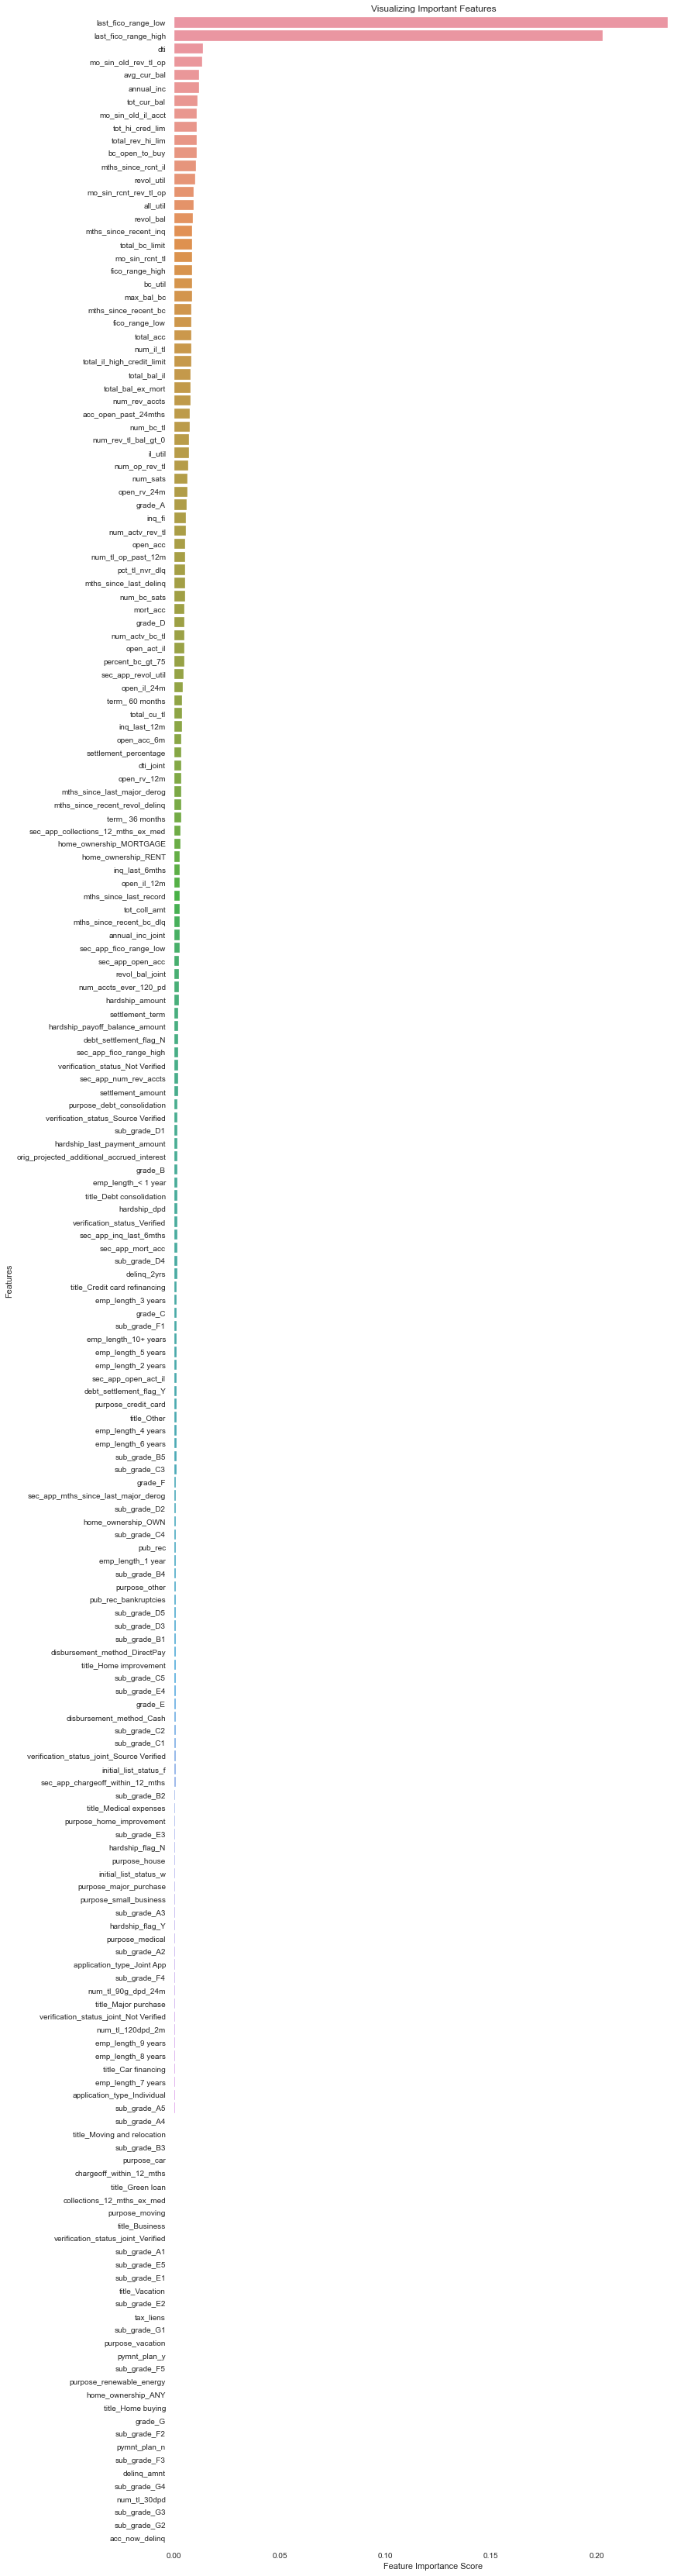

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig = plt.gcf()
fig.set_size_inches(12, 60)

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

<AxesSubplot:xlabel='Perf', ylabel='count'>

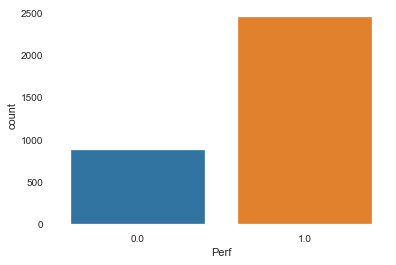

In [90]:
# From the remaining features, I will look at a possible correlation between DTI (Debt to Income) and 
#   the PaidInFull performance variable (Perf) by running a Logistic Regression Test.

sns.countplot(x='Perf', data=df_features)

In [91]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs',class_weight='balanced',max_iter=120000)

# Create arrays for the features and the response variable
y = df_features['Perf'].values
X_features = df_features[['Perf','dti']]
X = X_features.drop('Perf',axis=1).values

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=120000)

In [92]:
predictions = model.predict(X_test)

In [93]:
from sklearn.metrics import classification_report

classification_report(y_test, predictions)

'              precision    recall  f1-score   support\n\n         0.0       0.31      0.50      0.38       254\n         1.0       0.78      0.62      0.69       744\n\n    accuracy                           0.59       998\n   macro avg       0.54      0.56      0.54       998\nweighted avg       0.66      0.59      0.61       998\n'

In [94]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, predictions))

[[126 128]
 [284 460]]


In [98]:
# Looking at correlation between last_fico_range_low and Perf
df_features['Perf'].corr(df_features['last_fico_range_low'],method='pearson')

0.5791423235578518

In [99]:
# Looking at correlation between last_fico_range_low and Perf
df_features['Perf'].corr(df_features['last_fico_range_high'],method='pearson')

0.7102556649422719

In [100]:
# Looking at correlation between dti and Perf
df_features['Perf'].corr(df_features['dti'],method='pearson')

-0.04553847373302067